**Imports & Constants**

In [10]:
import random
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


In [11]:
SITE_WIDTH = 200
SITE_HEIGHT = 140

TOWER_A_SIZE = (30, 20)
TOWER_B_SIZE = (20, 20)

BOUNDARY_BUFFER = 10
MIN_BUILDING_DISTANCE = 15
NEIGHBOR_DISTANCE = 60

PLAZA_SIZE = 40
PLAZA_X = (SITE_WIDTH - PLAZA_SIZE) / 2
PLAZA_Y = (SITE_HEIGHT - PLAZA_SIZE) / 2


**Geometry Helper Functions**

In [12]:
def rectangles_overlap(r1, r2):
    return not (
        r1['x'] + r1['w'] <= r2['x'] or
        r2['x'] + r2['w'] <= r1['x'] or
        r1['y'] + r1['h'] <= r2['y'] or
        r2['y'] + r2['h'] <= r1['y']
    )


In [13]:
def rectangle_distance(r1, r2):
    dx = max(
        r2['x'] - (r1['x'] + r1['w']),
        r1['x'] - (r2['x'] + r2['w']),
        0
    )
    dy = max(
        r2['y'] - (r1['y'] + r1['h']),
        r1['y'] - (r2['y'] + r2['h']),
        0
    )
    return math.sqrt(dx * dx + dy * dy)


**Constraint Checking Function**

In [14]:
def check_partial_constraints(buildings):
    plaza = {
        'x': PLAZA_X,
        'y': PLAZA_Y,
        'w': PLAZA_SIZE,
        'h': PLAZA_SIZE
    }

    for b in buildings:
        if rectangles_overlap(b, plaza):
            return False

    for i in range(len(buildings)):
        for j in range(i + 1, len(buildings)):
            if rectangle_distance(buildings[i], buildings[j]) < MIN_BUILDING_DISTANCE:
                return False

    return True


**Layout Generator (Search Algorithm)**

In [15]:
def generate_layout(num_a, num_b, max_attempts=2500):
    buildings = []

    def random_building(b_type):
        w, h = TOWER_A_SIZE if b_type == 'A' else TOWER_B_SIZE
        return {
            'type': b_type,
            'w': w,
            'h': h,
            'x': random.uniform(BOUNDARY_BUFFER, SITE_WIDTH - w - BOUNDARY_BUFFER),
            'y': random.uniform(BOUNDARY_BUFFER, SITE_HEIGHT - h - BOUNDARY_BUFFER)
        }

    for b_type in ['A'] * num_a + ['B'] * num_b:
        placed = False
        for _ in range(max_attempts):
            candidate = random_building(b_type)
            if check_partial_constraints(buildings + [candidate]):
                buildings.append(candidate)
                placed = True
                break
        if not placed:
            return None

    for a in [b for b in buildings if b['type'] == 'A']:
        if not any(
            rectangle_distance(a, b) <= NEIGHBOR_DISTANCE
            for b in buildings if b['type'] == 'B'
        ):
            return None

    return buildings


**Scoring Function**

In [16]:
def compute_score(buildings):
    total_area = sum(b['w'] * b['h'] for b in buildings)

    tower_a = [b for b in buildings if b['type'] == 'A']
    tower_b = [b for b in buildings if b['type'] == 'B']

    proximity_score = 0
    for a in tower_a:
        min_dist = min(rectangle_distance(a, b) for b in tower_b)
        proximity_score += max(0, NEIGHBOR_DISTANCE - min_dist)

    xs = [b['x'] for b in buildings]
    ys = [b['y'] for b in buildings]
    spread_penalty = (max(xs) - min(xs)) + (max(ys) - min(ys))

    score = (
        20 * len(buildings) +
        0.03 * total_area +
        3.0 * proximity_score -
        0.15 * spread_penalty
    )

    return score


**Visualization**

In [17]:
def visualize_layout(buildings, title, score):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_facecolor('#ffffff')

    for x in range(0, SITE_WIDTH + 1, 10):
        ax.axvline(x, color='#eeeeee', linewidth=0.6, zorder=0)
    for y in range(0, SITE_HEIGHT + 1, 10):
        ax.axhline(y, color='#eeeeee', linewidth=0.6, zorder=0)

    ax.add_patch(
        plt.Rectangle((0, 0), SITE_WIDTH, SITE_HEIGHT,
                      fill=False, linewidth=2.5)
    )

    ax.add_patch(
        plt.Rectangle((PLAZA_X, PLAZA_Y), PLAZA_SIZE, PLAZA_SIZE,
                      fill=False, linestyle='--',
                      edgecolor='#2ecc71', linewidth=2.5)
    )
    ax.text(
        PLAZA_X + PLAZA_SIZE / 2,
        PLAZA_Y + PLAZA_SIZE / 2,
        "Central Plaza\n40 × 40 m",
        ha='center', va='center',
        fontsize=10, color='#2ecc71', fontweight='bold'
    )

    a_count, b_count = 0, 0
    built_area = 0

    for b in buildings:
        built_area += b['w'] * b['h']

        if b['type'] == 'A':
            color = '#ff6b6b'
            label = f"A{a_count+1}"
            a_count += 1
        else:
            color = '#4d79ff'
            label = f"B{b_count+1}"
            b_count += 1

        rect = plt.Rectangle(
            (b['x'], b['y']), b['w'], b['h'],
            color=color, alpha=0.8
        )
        ax.add_patch(rect)

        ax.text(
            b['x'] + b['w']/2,
            b['y'] + b['h']/2,
            label, color='white',
            fontsize=10, fontweight='bold',
            ha='center', va='center'
        )

    info = (
        f"Tower A: {a_count}\n"
        f"Tower B: {b_count}\n"
        f"Built Area: {built_area:.0f} m²\n"
        f"Score: {score:.1f}"
    )

    ax.text(
        0.02, 0.98, info,
        transform=ax.transAxes,
        va='top', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.95)
    )

    legend_elements = [
        Patch(facecolor='#ff6b6b', label='Tower A (Primary)'),
        Patch(facecolor='#4d79ff', label='Tower B (Secondary)'),
        Patch(facecolor='none', edgecolor='#2ecc71',
              linestyle='--', linewidth=2, label='Central Plaza')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlim(-15, SITE_WIDTH + 15)
    ax.set_ylim(-15, SITE_HEIGHT + 15)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()


**Generate & Select Best Layouts**

Valid layouts found: 587


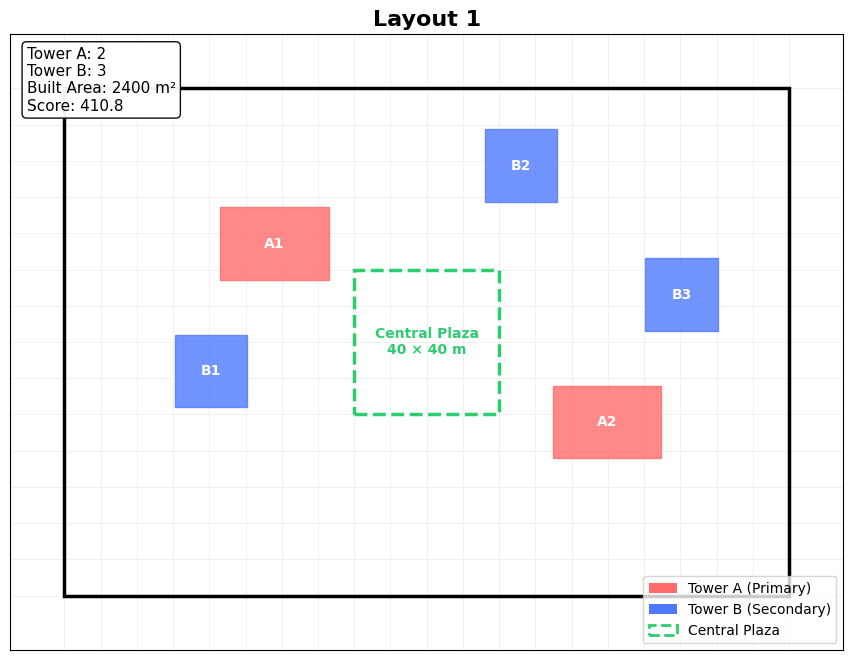

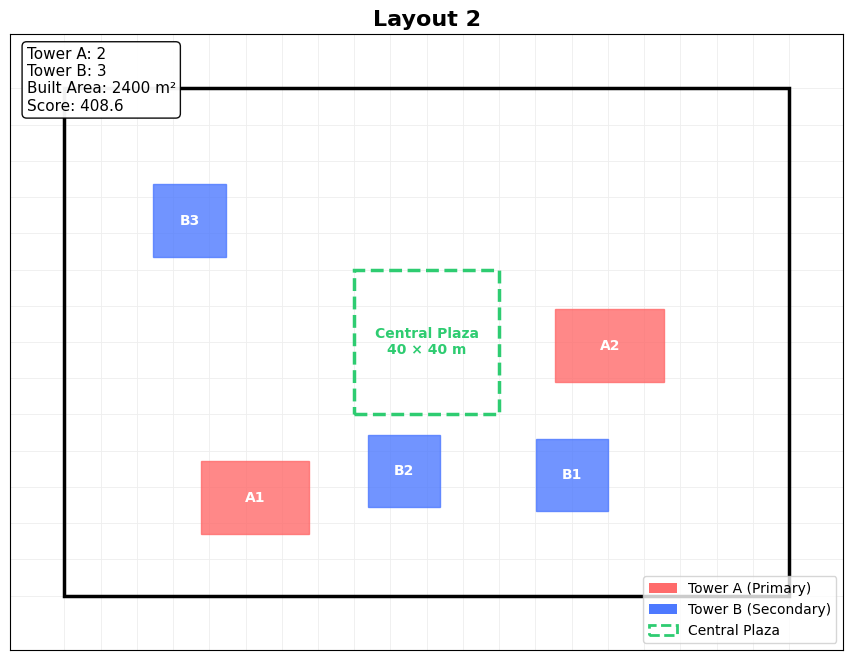

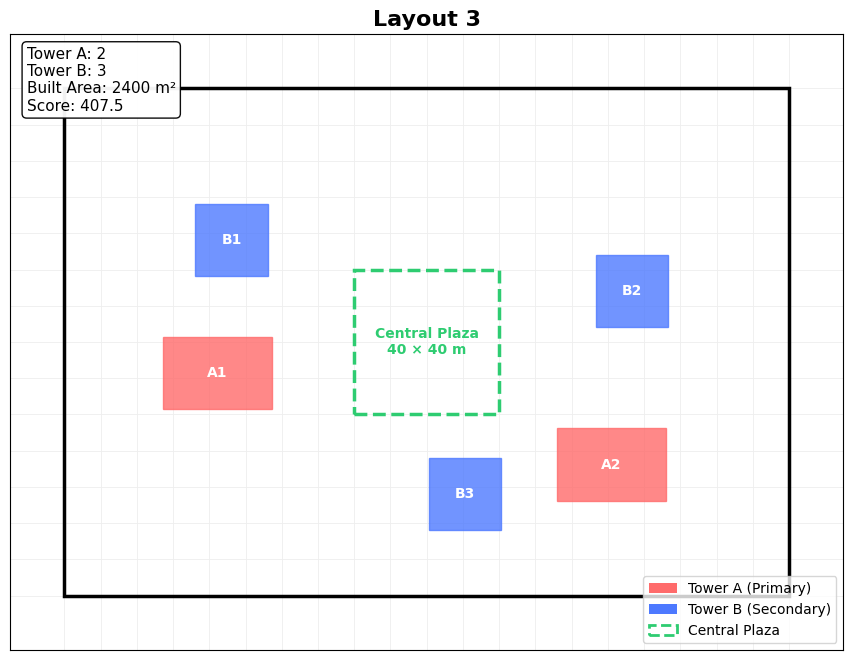

In [18]:
layouts = []

for _ in range(700):
    layout = generate_layout(num_a=2, num_b=3)
    if layout:
        layouts.append((compute_score(layout), layout))

print("Valid layouts found:", len(layouts))

layouts.sort(reverse=True, key=lambda x: x[0])
top_layouts = layouts[:3]

for i, (score, layout) in enumerate(top_layouts):
    visualize_layout(layout, f"Layout {i+1}", score)
